# import libraries

In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter,find_peaks

from tqdm import tqdm

import time

from impedance.visualization import plot_nyquist
from impedance import preprocessing

# import raw data to MySQL

## read mpr files to pandas dataframe

### read Formation data

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#load data from folder
df_form = read_mpr.mpr_pandas('raw_data/form')

In [5]:
read_mpr.searchmpr('raw_data/form')

['raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1t

In [6]:
df_form[1]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle,loop_Nr,cycle_Nr
0,15,0,1.680460e+03,-3.409833e-10,-3.409833e-10,0.00,-0.161267,115,-3.409833e-10,0,0,1
1,15,0,1.685460e+03,0.000000e+00,-3.409833e-10,0.00,-0.161267,115,-3.409833e-10,0,0,1
2,31,0,1.690486e+03,0.000000e+00,-3.409833e-10,0.02,0.173130,117,-3.409833e-10,0,0,1
3,53,1,1.690488e+03,1.106957e-08,1.072859e-08,0.02,0.184352,117,1.072859e-08,0,0,1
4,21,1,1.695488e+03,2.772917e-05,2.773990e-05,0.02,0.867360,117,2.773990e-05,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
189758,23,1,2.191576e+06,0.000000e+00,2.462457e-01,0.00,2.056041,115,4.008953e+00,0,9,10
189759,23,1,2.191581e+06,0.000000e+00,2.462457e-01,0.00,2.056041,115,4.008953e+00,0,9,10
189760,23,1,2.191586e+06,0.000000e+00,2.462457e-01,0.00,2.056119,115,4.008953e+00,0,9,10
189761,23,1,2.191591e+06,0.000000e+00,2.462457e-01,0.00,2.055962,115,4.008953e+00,0,9,10


#### add serval columns

In [7]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/form/*.mpr')
datafilespath =  [os.path.basename(x) for x in datafilespath]

In [8]:
datafilespath

['Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA4.mpr',
 'Cell005_Form_100uA_25T_30RH_Cycle1to10_01_GEIS_CA5.mpr',
 'Cell005_For

##### half cycle and state of charge

In [9]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    df_form[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    df_form[index]['state of charge']=0
for index in cell_full_index:
    df_form[index]['state of charge']=1

In [10]:
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
discharge_index

array([ 3,  7, 11, 15, 19, 23, 27, 31])

### read Cycling data

In [11]:
df_cycle = read_mpr.mpr_pandas('raw_data/cycle_new')

In [12]:
cyc_files = glob('raw_data/cycle/*.mpr')
for file in cyc_files:
    try:
        BioLogic.MPRfile(file)
    except:
        print('files: '+file+' is unreadable')

similar issue: https://github.com/echemdata/galvani/issues/39

# import dataframes to Mysql

## Structure 1(deprecated):    
cell001:     
-step01_geis    
-step02_gcpl    
-step03_geis    
-step04_gcpl    

In [1]:
##structure 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(df_form))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    # capacity
    
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if step_ID[j]=='02':
            df_form[j].to_sql('step'+step_ID[j]+'_'+'charge', engine, if_exists='fail',index=False)
        elif step_ID[j]=='04':
            df_form[j].to_sql('step'+step_ID[j]+'_'+'discharge', engine, if_exists='fail',index=False)
        else:
            df_form[j].to_sql('step'+step_ID[j]+'_'+Tech_Type[j], engine, if_exists='fail',index=False)
            
        print('table '+'step'+step_ID[j]+'_'+Tech_Type[j]+' of '+Cell_ID[i]+' created')
        
print('All data loaded')


NameError: name 'pymysql' is not defined

## Structure 2:    
cell001:    
-geis    
-gcpl    

In [ ]:
#structure 2
#We prefer this structure!
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
datafilespath_form = glob('raw_data/form/*.mpr')
datafilespath_form = [os.path.basename(x) for x in datafilespath_form]
datafilespath_cyc = glob('raw_data/cycle/*.mpr')
datafilespath_cyc = [os.path.basename(x) for x in datafilespath_cyc]
datafilespath = np.append(datafilespath_form,datafilespath_cyc)
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')


##formation labor data
Cell_ID = np.unique([x.split('_')[0] for x in datafilespath_form])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath_form],return_index=True)[1],len(df_form))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath_form]
print('='*100+'\nForm data:')
form_start_time = time.time()
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath_form]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([df_form[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data=geis_data.sort_values(by=['time/s'])
    geis_data.to_sql('form_geis', engine, if_exists='fail',index=False,chunksize = 80000)
    print('geis data of '+Cell_ID[i]+ ' uploaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([df_form[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data=gcpl_data.sort_values(by=['time/s'])
    gcpl_data.to_sql('form_gcpl', engine, if_exists='fail',index=False,chunksize = 80000)    
    print('gcpl data of '+Cell_ID[i]+ ' uploaded')    

form_end_time = time.time()
print('formation data processing time: ', form_end_time - form_start_time,'s')
print('='*100+'\nCycle data:')
##cycling labor data   
db=np.unique([x.split('_')[0] for x in datafilespath_cyc])
cyc_start_time = time.time()
for cell,index in zip(db,range(0,16,2)):
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)   
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    df_cycle[index].to_sql('cyc_geis', engine, if_exists='replace',index=False,chunksize = 80000)
    print('geis data of '+cell+ ' uploaded')
    df_cycle[index+1].to_sql('cyc_gcpl', engine, if_exists='replace',index=False,chunksize = 80000)
    print('gcpl data of '+cell+ ' uploaded')
    
print('='*100)
print('All data uploaded')

cyc_end_time = time.time()

print('cycling data processing time: ', cyc_end_time - cyc_start_time,'s')


without chunksize:    
    formation data processing time:  249.83825254440308 s    
    cycling data processing time:  1045.3779447078705 s
   
chunksize = 50000(best one!)   
    formation data processing time:  184.6444227695465 s    
    cycling data processing time:  921.2041549682617 s

chunksize = 5000    
    formation data processing time:  212.5893361568451 s    
    cycling data processing time:  1058.742508172989 s
    
chunksize = 10000   
    formation data processing time:  214.2786316871643 s    
    cycling data processing time:  1023.5620315074921 s

chunksize = 30000   
    formation data processing time:  215.41345477104187 s    
    cycling data processing time:  1060.0271468162537 s


# Savitzky-Golay filter

## charge/discharge curve

In [ ]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)

# structue 2
sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` FROM form_gcpl'
cursor = Connection.cursor()
cursor.execute(sql)
curve = cursor.fetchall()
curve = np.array(curve)

In [ ]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,0], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(curve[:,2], curve[:,1],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)


p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],111,3), "y",label='filtered Ewe')

fig.legend()
## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 199,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polynomial order', valmin = 2,valmax = 9,valinit = 3,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()


# cell capacity
create a table of each cell to discribe its capacity in all loops

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)
    #formation
    sql = 'SELECT `(Q-Qo)/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.form_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['(Q-Qo)/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h'].min())
    capacity_form = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity_form['cycle type'] = 'Formation'
    capacity_form = pd.DataFrame(data=capacity_form)


    
    #cycling
    sql = 'SELECT `Q charge/discharge/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.cyc_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['Q charge/discharge/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['Q charge/discharge/mA.h'].min())
    capacity_cycle = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity_cycle['cycle type'] = 'Cycling'
    capacity_cycle = pd.DataFrame(data=capacity_cycle,index=cycle_Nr)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    
    capacity = pd.concat([capacity_form,capacity_cycle])
    capacity.to_sql('capacity', engine, if_exists='replace',index=False)
    print('table capacity of '+cell +' created')

In [ ]:
capacity.loc[32:50]

why somtimes CE > 100%    
explain in:https://www.researchgate.net/post/In_battery_tests_is_coulombic_efficiency_over_100_have_a_particular_meaning

# Fix error in cycling data 

## check the unnormal parts

In [ ]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell002'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)
# structue 2
sql = 'SELECT `Q charge/discharge/mA.h`,`Ewe/V`, `time/s`,`cycle_Nr` FROM cyc_gcpl'
print('data queried')
cell_df = pd.read_sql(sql,Connection)

In [ ]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(cell_df['time/s'], cell_df['Q charge/discharge/mA.h'], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(cell_df['time/s'], cell_df['Ewe/V'],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)
fig.legend()



plt.show()


In [ ]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
error_index = np.isin(cell_df['cycle_Nr'],[31,32,33])
ax.plot(cell_df['time/s'][error_index], cell_df['Q charge/discharge/mA.h'][error_index], color="red",label='Q-Qo')
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

#vertical lines to distinguish different cycle
time_31_32 = cell_df['time/s'][cell_df['cycle_Nr']==31].max()
time_32_33 = cell_df['time/s'][cell_df['cycle_Nr']==32].max()
ax.axvline(time_31_32,color='green',linestyle='--')
ax.axvline(time_32_33,color='green',linestyle='--')

ax2=ax.twinx()
ax2.plot(cell_df['time/s'][error_index], cell_df['Ewe/V'][error_index],"b-",label='Ewe')
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)

fig.legend()



plt.show()


The whole cycle 32 looks weird.

In [ ]:
t_30 = cell_df['time/s'][cell_df['cycle_Nr']==30].max() - cell_df['time/s'][cell_df['cycle_Nr']==30].min()
t_31 = cell_df['time/s'][cell_df['cycle_Nr']==31].max() - cell_df['time/s'][cell_df['cycle_Nr']==31].min()
t_32 = cell_df['time/s'][cell_df['cycle_Nr']==32].max() - cell_df['time/s'][cell_df['cycle_Nr']==32].min()
t_33 = cell_df['time/s'][cell_df['cycle_Nr']==33].max() - cell_df['time/s'][cell_df['cycle_Nr']==33].min()
t_34 = cell_df['time/s'][cell_df['cycle_Nr']==34].max() - cell_df['time/s'][cell_df['cycle_Nr']==34].min()
print('time of cycle 30: '+str(round(t_30))+'s')
print('time of cycle 31: '+str(round(t_31))+'s')
print('time of cycle 32: '+str(round(t_32))+'s')
print('time of cycle 33: '+str(round(t_33))+'s')
print('time of cycle 34: '+str(round(t_34))+'s')

## find the cycle number

In [ ]:
def find_error_cycle_numbers(cell_df):
    cycle_numbers = []
    for i in  tqdm(range(1, len(cell_df['time/s']))):
        if cell_df['time/s'][i]-cell_df['time/s'][i-1]>10000:
            return [cell_df['cycle_Nr'][i-1],cell_df['cycle_Nr'][i]]
    

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cells=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

cyc = []
for cell in cells:
    Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=cell)

    sql = 'SELECT `Q charge/discharge/mA.h`,`Ewe/V`, `time/s`,`cycle_Nr` FROM cyc_gcpl'
    print(cell,' data queried')
    cell_df = pd.read_sql(sql,Connection)
    cyc.append(find_error_cycle_numbers(cell_df))
cyc

In [ ]:
cycles

## remove these cycles

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cells = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cycles,cell in  zip(cyc,cells):
    Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=cell)
    cycles = np.unique(cycles)
    if len (cycles) == 1:
        sql = 'DELETE FROM cyc_gcpl WHERE cycle_Nr={}'.format(cycles[0])
    else:
        sql = 'DELETE FROM cyc_gcpl WHERE cycle_Nr={} or cycle_Nr={}'.format(cycles[0],cycles[1])
    cursor = Connection.cursor()
    cursor.execute(sql)
    Connection.commit()
    print('deleted from {}'.format(cell))

# $V$,$\frac {dV}{dt}$,$\frac{d(\frac {dV}{dt})}{dt}$ vs. time

## Formation Phase

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_time=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`time/s`,`half cycle`,`loop_Nr` FROM ' +cell+ '.form_gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    t =cellx_df['time/s']
    half_cycle = cellx_df['half cycle']
    loop_Nr = cellx_df['loop_Nr']
    
    #with savgol_filter
    dV_sg = np.divide(np.diff(V_sg,append=-1),np.diff(t,append=-1))
#     ddV_sg = np.divide(np.diff(dV_sg,append=-1),np.diff(t,append=-1))
    #without savgpl_filter
    dV = np.divide(np.diff(V,append=-1),np.diff(t,append=-1))
    #2th derivative
    ddV = np.divide(np.diff(savgol_filter(dV_sg,win_len,p_order),append=-1),np.diff(t,append=-1))
    #apply filter twice
#     ddV_sgsg = savgol_filter(ddV,win_len,p_order)
    
    
    
    derivative_of_v_to_time = {'V':V,'V_sg':V_sg,'dV':dV,'dV_sg':dV_sg,'ddV':ddV,'t':t,'half cycle':half_cycle,'loop_Nr':loop_Nr}
    derivative_of_v_to_time = pd.DataFrame(data=derivative_of_v_to_time)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    derivative_of_v_to_time.to_sql('derivative_of_v_to_time_form', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table derivative_of_v_to_time of '+cell +' created')

In [39]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

# query from Mysql
sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_form'
cellx_df = pd.read_sql(sql, Connection)
sql = 'SELECT `(Q-Qo)/mA.h` FROM ' +cell+ '.form_gcpl'
Q = pd.read_sql(sql, Connection)

print('data queried')
V = cellx_df['V'].copy()
V_sg = cellx_df['V_sg'].copy()
t = cellx_df['t'].copy()
dV = cellx_df['dV'].copy()
dV_sg = cellx_df['dV_sg'].copy()
ddV = cellx_df['ddV'].copy()
half_cycle = cellx_df['half cycle'].copy()
loop_Nr = cellx_df['loop_Nr'].copy()

data queried


In [40]:
# time series not normal，makes the calculation of dV noisy
for i in range(1,len(t)):
    if t[i]-t[i-1]<4:
        print(i,t[i]-t[i-1],dV[i])
        

3 0.0020000000949949026 0.13660159351177248
20663 2.302000115858391 0.0
20664 0.0020000000949949026 -0.019999999050034013
20665 0.02400000113993883 0.0
23968 1.298000065376982 -0.03999999810014204
23969 0.0020000000949949026 -0.16219999229591056
23970 0.050000002374872565 -0.006291999683566416
27571 0.05800000624731183 -6.839497089025371e-06
27575 0.0020000003278255463 -0.008047999160528237
37440 1.3900001449510455 0.07874639625974689
37441 0.0020000000949949026 -0.018172267391234218
37442 0.026000002631917596 -7.874799178594437e-06
51843 0.05200000572949648 0.00016536778275079607
55444 0.05800000578165054 2.5759072553339956e-06
55448 0.0020000003278255463 0.007717179195035484
77160 2.234000233002007 -0.039999993443530155
77161 0.0020000003278255463 -0.01285714160497835
77162 0.0280000027269125 7.999999165498652e-06
81221 1.3980001455638558 0.0
81222 0.0020000000949949026 -0.11296295029161162
81223 0.054000006057322025 -0.001699999822676235
84824 0.05800000578165054 -8.992590879214065e

In [41]:
def remove_jumps(data,jump_threshold=0.001):
    '''
    remove peaks
    first remove peaks, if one point has too big different with neighboor two points, replace the value by the mean of lest and right values
    '''
    #peaks
    p=0
    for i in range(1,len(data)-1):
        p = min(abs(data[i]-data[i-1]), abs(data[i+1]-data[i]))
        if p >= jump_threshold:
            data[i]=(data[i-1]+data[i+1])/2
#step 
#     s=0
#     for i in range(1,len(data)-1):
#         s=abs(data[i]-data[i-1])
#         if s >= jump_threshold:
#             data[i]=(data[i-1]+data[i+1])/2
    return data
    

def find_extreme_point(data,half_cycle,loop_Nr):
    '''
    this func helps find all turning points in the whole curve
    afterwards some should be filtered
    data should be continuous for application find_peaks
    '''
    index=[]
    for loop in np.unique(loop_Nr):
        for soc in np.unique(half_cycle):
            tmp = data[(half_cycle==soc)&(loop_Nr==loop)].copy()
#             if soc == 1:tmp = -tmp# discharge phase
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=-0.001,distance=50)
            index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
    #we want positive and negative peaks
            tmp = -tmp
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=[None,0.001],distance=50)
            index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
    return [int(i) for i in index]


def remove_constant_V(dV,dV_sg,ddV):
    '''
    when V = 2.4 or 0(constant, actual value c.a. 2.399 and -0.0003) remove the impact of these sections of time 
    in this case dV/dt is 0 and doesn't make sense
    '''

    dV.loc[V_sg>2.398]=np.nan
    dV.loc[V_sg<-0.00001]=np.nan
    dV_sg.loc[V_sg>2.398]=np.nan
    dV_sg.loc[V_sg<-0.00001]=np.nan
    ddV.loc[V_sg>2.35]=np.nan
    ddV.loc[V_sg<0.02]=np.nan


    nan_mask = np.ma.clump_masked(np.ma.masked_invalid(dV_sg))
    for ma in nan_mask:
        ma = np.r_[ma]
        #remove a bit more points to get better results, if points just at start or end of curves, just do as normal
        if ma[0]-100 <0:
            ma = np.append(np.array(range(0,ma[0])),ma)
        else:
            ma = np.append(np.array(range(ma[0]-100,ma[0])),ma)
#         ma = ma.astype(int)
        if  ma[-1]+100 > dV.keys().stop:
            ma = np.append(ma,np.array(range(ma[-1],dV.keys().stop)))
        else:
            ma = np.append(ma,np.array(range(ma[-1],ma[-1]+100)))
        
        dV.loc[ma] = np.nan
        dV_sg.loc[ma] = np.nan
        ddV.loc[ma] = np.nan
    return dV,dV_sg,ddV

def remove_EIS(dV,dV_sg,ddV):
    # in dV and ddV, remove the data in EIS phases

    ## get the time points of all eis processes
    sql = 'SELECT `time/s`,`loop_Nr`,`state of charge` FROM ' +cell+ '.form_geis'
    eis_time = pd.read_sql(sql, Connection)
    time=[]
    for ln in np.unique(eis_time['loop_Nr']):
        for soc in np.unique(eis_time['state of charge']):
            start = eis_time.loc[(eis_time['loop_Nr']==ln) & (eis_time['state of charge']==soc)]['time/s'].min()
            end = eis_time.loc[(eis_time['loop_Nr']==ln) & (eis_time['state of charge']==soc)]['time/s'].max()
            time = np.append(time,[start,end])

    time=time.reshape((-1,2))

    ## in dV and ddV, replace with np.nan
    delta_t = 800
    for start,end in time:
        dV.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        dV_sg.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        ddV.loc[(t>start-3*delta_t)&(t<end+2*delta_t)] = np.nan
    #     ddV.loc[(t>start-delta_t)&(t<end+delta_t)] = np.nan
    #     ddV_sg.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan



    # just delete the time between removed phase and eis phase,as Q change almost not
    mask_unnan=np.ma.clump_unmasked(np.ma.masked_invalid(dV_sg))
    for loop in np.unique(loop_Nr):
        for soc in np.unique(half_cycle):
            #only do it if 2 sections in the array
            if len(mask_unnan)==4*len(np.unique(loop_Nr)):
                if soc == 0:
                    dV.loc[mask_unnan[1+4*loop]]=np.nan
                    dV_sg.loc[mask_unnan[1+4*loop]]=np.nan
                    ddV.loc[mask_unnan[1+4*loop]]=np.nan
                elif soc == 1:
                    dV.loc[mask_unnan[3+4*loop]]=np.nan
                    dV_sg.loc[mask_unnan[3+4*loop]]=np.nan
                    ddV.loc[mask_unnan[3+4*loop]]=np.nan
                else:
                    raise ValueError('soc should be either 0 or 1')
            else:
                break
    return dV,dV_sg,ddV



In [42]:
# dV=remove_jumps(dV,0.001)
# dV_sg=remove_jumps(dV_sg,0.001)
ddV=remove_jumps(ddV,0.001)
point_index = find_extreme_point(ddV,half_cycle,loop_Nr)
# dV,dV_sg,ddV = remove_constant_V(dV,dV_sg,ddV)
# dV,dV_sg,ddV = remove_EIS(dV,dV_sg,ddV)

<IPython.core.display.Javascript object>


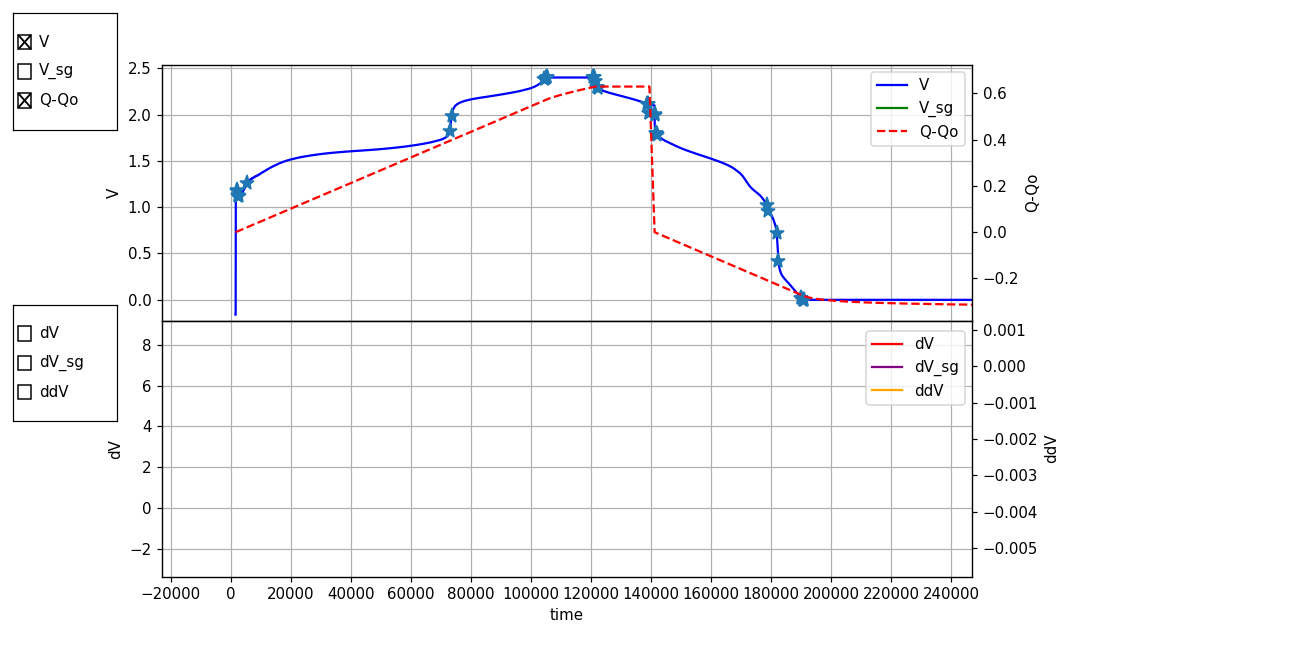

In [43]:
#plot the curves
%matplotlib notebook
## axis

fig,ax = plt.subplots(2,1,figsize=(12,6), sharex=True)
fig.subplots_adjust(right=0.75,top=0.9,hspace=.0)


ax[0].grid()
ax[1].grid()
ax1=ax[0].twinx()
ax2=ax[1].twinx()
ax[0].locator_params(axis='x', nbins=15)

#plot curves
p1,=ax[0].plot(t,V, color="blue", label='V',visible=True)
p1_sg,= ax[0].plot(t,V_sg, color="green", label='V_sg',visible=True)
q, = ax1.plot(t,Q, color="red",linestyle='--', label='Q-Qo',visible=True)
p2,=ax[1].plot(t,dV, color="red", label='dV',visible=True)
p2_sg,=ax[1].plot(t,dV_sg, color="purple", label='dV_sg',visible=True)
p3,=ax2.plot(t,ddV, color="orange", label='ddV',visible=True)


#plot points
invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
point_index = np.delete(point_index, invalid_point_index)
# point_index = remove_trash_points(point_index,cell=cell,tech_type='form')#defined in next section
point_dV = ax[1].plot(t[point_index], [dV_sg[i] for i in point_index],'*',markersize=10,visible=True)
point_V = ax[0].plot(t[point_index], [V_sg[i] for i in point_index],'*',markersize=10,visible=True)
point_ddV = ax2.plot(t[point_index], [ddV[i] for i in point_index],'*',markersize=10,visible=True)

#set visible
fig.legend([p1,p1_sg,q],['V','V_sg','Q-Qo'],bbox_to_anchor=(0.75, 0.9))
fig.legend([p2,p2_sg,p3],['dV','dV_sg','ddV'],bbox_to_anchor=(0.75, 0.5))
p1_sg.set_visible(False)
p2.set_visible(False)
p2_sg.set_visible(False)
p3.set_visible(False)
point_dV[0].set_visible(False)
point_V[0].set_visible(True)
point_ddV[0].set_visible(False)

#x labels
ax[1].set_xlabel("time")
ax[0].set_ylabel("V")
ax1.set_ylabel("Q-Qo")
ax[1].set_ylabel("dV")
ax2.set_ylabel("ddV")


## define the checkboxes
ax_cb1 = plt.axes([0.01,0.8,0.08,0.18])
ax_cb2 = plt.axes([0.01,0.35,0.08,0.18])

## properties of checkboxes
cbs1 = CheckButtons(ax_cb1,['V','V_sg','Q-Qo'],actives=[True,False,True])
cbs2 = CheckButtons(ax_cb2,['dV','dV_sg','ddV'],actives=[False,False,False])
## updating function
def update(val):
    status1 = cbs1.get_status()
    status2 = cbs2.get_status()
    p1.set_visible(status1[0])
    p1_sg.set_visible(status1[1])
    q.set_visible(status1[2])
    p2.set_visible(status2[0])
    p2_sg.set_visible(status2[1])
    point_dV[0].set_visible(status2[1])
    point_ddV[0].set_visible(status2[2])
    p3.set_visible(status2[2])

    fig.canvas.draw()
    
cbs1.on_clicked(update)
cbs2.on_clicked(update)

plt.show()

## Cycling Phase

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_time=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`time/s`,`half cycle`,`cycle_Nr` FROM ' +cell+ '.cyc_gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    t =cellx_df['time/s']
    half_cycle = cellx_df['half cycle']
    cycle_Nr = cellx_df['cycle_Nr']
    
    #with savgol_filter
    dV_sg = np.divide(np.diff(V_sg,append=-1),np.diff(t,append=-1))
#     ddV_sg = np.divide(np.diff(dV_sg,append=-1),np.diff(t,append=-1))
    #without savgpl_filter
    dV = np.divide(np.diff(V,append=-1),np.diff(t,append=-1))
    #2th derivative
    ddV = np.divide(np.diff(savgol_filter(dV_sg,win_len,p_order),append=-1),np.diff(t,append=-1))
#     ddV = np.divide(np.diff(dV,append=-1),np.diff(t,append=-1))
    #apply filter twice
#     ddV_sgsg = savgol_filter(ddV,win_len,p_order)
    
    
    
    derivative_of_v_to_time = {'V':V,'V_sg':V_sg,'dV':dV,'dV_sg':dV_sg,'ddV':ddV,'t':t,'half cycle':half_cycle,'cycle_Nr':cycle_Nr}
    derivative_of_v_to_time = pd.DataFrame(data=derivative_of_v_to_time)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    derivative_of_v_to_time.to_sql('derivative_of_v_to_time_cyc', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table derivative_of_v_to_time of '+cell +' created')

In [18]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

# query from Mysql
sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_cyc'
cellx_df = pd.read_sql(sql, Connection)
sql = 'SELECT `Q charge/discharge/mA.h` FROM ' +cell+ '.cyc_gcpl'
Q = pd.read_sql(sql, Connection)

print('data queried')
V = cellx_df['V'].copy()
V_sg = cellx_df['V_sg'].copy()
t = cellx_df['t'].copy()
dV = cellx_df['dV'].copy()
dV_sg = cellx_df['dV_sg'].copy()
ddV = cellx_df['ddV'].copy()
half_cycle = cellx_df['half cycle'].copy()
cycle_Nr = cellx_df['cycle_Nr'].copy()

data queried


In [19]:
def find_extreme_point_cyc(ddV,half_cycle,cycle_Nr):
    '''
    this func helps find all extreme points in the whole curve
    afterwards some should be filtered
    dV_sg should be continuous
    '''
    index=[]
    for cycle in np.unique(cycle_Nr):
        for soc in np.unique(half_cycle):
            tmp = ddV[(half_cycle==soc)&(cycle_Nr==cycle)].copy()#data of one cycle charge or discharge step
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=-0.001,distance=50)
            if np.size(num_peaks[0])!=0:
                index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
            tmp = -tmp# find negative peaks
            num_peaks = find_peaks(tmp, prominence =0.0000001,height=[None,0.001],distance=50) 
            if np.size(num_peaks[0])!=0:
                index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
    return [int(i) for i in index]


def remove_EIS_cyc(dV,dV_sg,ddV):
    # in dV and ddV, remove the data in EIS phases

    ## get the time points of all eis processes
    sql = 'SELECT `time/s`,`cycle_Nr` FROM ' +cell+ '.cyc_geis'
    eis_time = pd.read_sql(sql, Connection)
    time=[]
    for cn in np.unique(eis_time['cycle_Nr']):
        start = eis_time.loc[eis_time['cycle_Nr']==cn]['time/s'].min()
        end = eis_time.loc[eis_time['cycle_Nr']==cn]['time/s'].max()
        time = np.append(time,[start,end])

    time=time.reshape((-1,2))

    ## in dV and ddV, replace with np.nan
    delta_t = 800
    for start,end in time:
        dV.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        dV_sg.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        ddV.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        
    return dV,dV_sg,ddV

In [20]:
# dV=remove_jumps(dV,0.001)
# dV_sg=remove_jumps(dV_sg,0.001)
ddV=remove_jumps(ddV,0.000005)
point_index = find_extreme_point_cyc(ddV,half_cycle,cycle_Nr)
# dV,dV_sg,ddV = remove_constant_V(dV,dV_sg,ddV)
# dV,dV_sg,ddV = remove_EIS_cyc(dV,dV_sg,ddV)

<IPython.core.display.Javascript object>


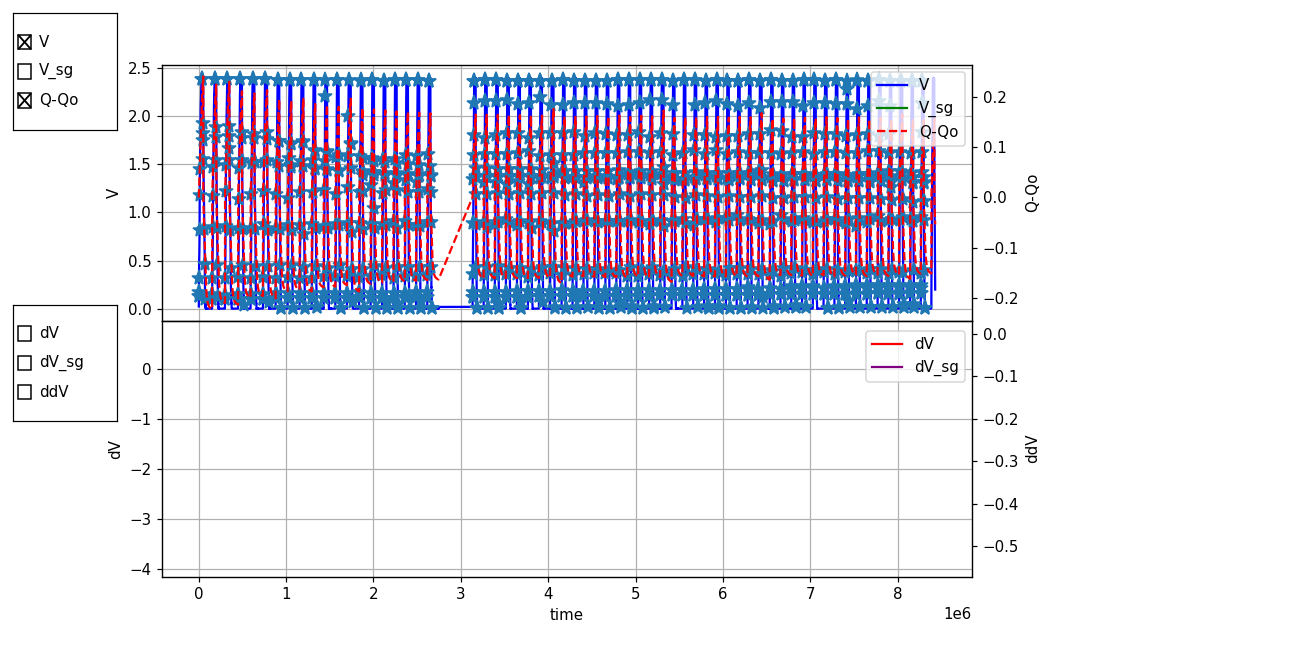

In [23]:
#plot the curves
%matplotlib notebook
## axis

fig,ax = plt.subplots(2,1,figsize=(12,6), sharex=True)
fig.subplots_adjust(right=0.75,top=0.9,hspace=.0)


ax[0].grid()
ax[1].grid()
ax1=ax[0].twinx()
ax2=ax[1].twinx()
ax[0].locator_params(axis='x', nbins=15)

#plot curves
p1,=ax[0].plot(t,V, color="blue", label='V',visible=True)
p1_sg,= ax[0].plot(t,V_sg, color="green", label='V_sg',visible=True)
q, = ax1.plot(t,Q, color="red",linestyle='--', label='Q-Qo',visible=True)
p2,=ax[1].plot(t,dV, color="red", label='dV',visible=True)
p2_sg,=ax[1].plot(t,dV_sg, color="purple", label='dV_sg',visible=True)
p3,=ax2.plot(t,ddV, color="orange", label='ddV',visible=True)

#plot points
invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
point_index = np.delete(point_index, invalid_point_index)
point_index = remove_trash_points(point_index,cell=cell,tech_type='cyc')#defined in next section
point_dV = ax[1].plot(t[point_index], [dV_sg[i] for i in point_index],'*',markersize=10,visible=True)
point_V = ax[0].plot(t[point_index], [V[i] for i in point_index],'*',markersize=10,visible=True)
point_ddV = ax2.plot(t[point_index], [ddV[i] for i in point_index],'*',markersize=10,visible=True)

#set visible
fig.legend([p1,p1_sg,q],['V','V_sg','Q-Qo'],bbox_to_anchor=(0.75, 0.9))
fig.legend([p2,p2_sg],['dV','dV_sg'],bbox_to_anchor=(0.75, 0.5))
p1_sg.set_visible(False)
p2.set_visible(False)
p2_sg.set_visible(False)
p3.set_visible(False)
point_dV[0].set_visible(False)
point_V[0].set_visible(True)
point_ddV[0].set_visible(False)

#x labels
ax[1].set_xlabel("time")
ax[0].set_ylabel("V")
ax1.set_ylabel("Q-Qo")
ax[1].set_ylabel("dV")
ax2.set_ylabel("ddV")


## define the checkboxes
ax_cb1 = plt.axes([0.01,0.8,0.08,0.18])
ax_cb2 = plt.axes([0.01,0.35,0.08,0.18])

## properties of checkboxes
cbs1 = CheckButtons(ax_cb1,['V','V_sg','Q-Qo'],actives=[True,False,True])
cbs2 = CheckButtons(ax_cb2,['dV','dV_sg','ddV'],actives=[False,False,False])
## updating function
def update(val):
    status1 = cbs1.get_status()
    status2 = cbs2.get_status()
    p1.set_visible(status1[0])
    p1_sg.set_visible(status1[1])
    q.set_visible(status1[2])
    p2.set_visible(status2[0])
    p2_sg.set_visible(status2[1])
    p3.set_visible(status2[2])
    point_dV[0].set_visible(status2[1])
    point_ddV[0].set_visible(status2[2])
    
    fig.canvas.draw()
    
cbs1.on_clicked(update)
cbs2.on_clicked(update)

plt.show()

## transfer points info to Mysql

### remove useless points

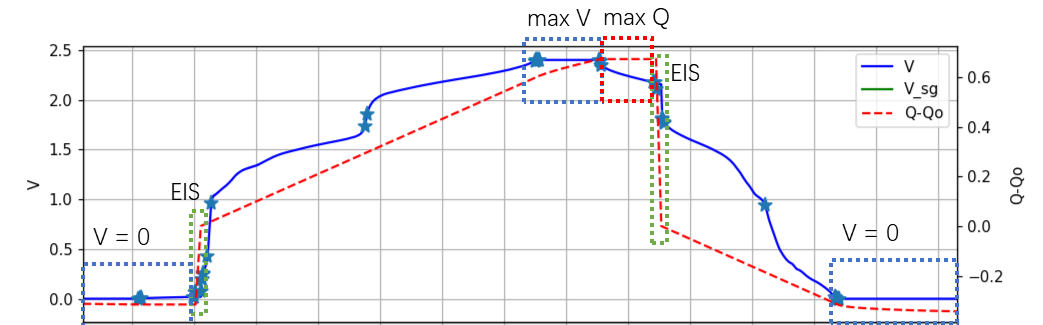



we need the tunning points to locate in:<br>
- charge: after Q=0 (beginning of charge) to before max V(2.39) 
- discharge: after Q=0 (beginning of discharge)to before V=0

In [22]:
def remove_trash_points(point_index,cell='cell001',tech_type='form'):
    if tech_type=='form':
        Q = '(Q-Qo)/mA.h'    
    elif tech_type=='cyc':
        Q = 'Q charge/discharge/mA.h'
    else: raise ValueError('no such technique step!')  
        
    sql = 'SELECT `{Q}`,`Ewe/V`,`half cycle`,`cycle_Nr` FROM {schema}.{tech_type}_gcpl'.format(Q=Q,schema=cell,tech_type=tech_type)
    
    cellx_df = pd.read_sql(sql, Connection)
    valid_index = []
    for cyc in np.unique(cellx_df['cycle_Nr']):
        charge_start = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==0)&(cellx_df[Q]>0.001)].index.min()
        charge_end = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==0)&(cellx_df['Ewe/V']>2.39)].index.min()
        discharge_start = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==1)&(cellx_df[Q]<-0.001)].index.min()
        discharge_end = cellx_df[(cellx_df['cycle_Nr']==cyc)&(cellx_df['half cycle']==1)&(cellx_df['Ewe/V']<0.01)].index.min()
        if np.nan in [charge_start,charge_end,discharge_start,discharge_end]:# in case the test not finished
            continue
        valid_index = np.append(valid_index,np.arange(charge_start,charge_end+1))
        valid_index = np.append(valid_index,np.arange(discharge_start,discharge_end+1))
    mask = np.isin(valid_index, point_index)    
    point_index = valid_index[mask]
    return point_index
            

### formation

In [26]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cell in db:
    
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    # query from Mysql
    sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_form'
    cellx_df = pd.read_sql(sql, Connection)
    sql = 'SELECT `(Q-Qo)/mA.h` FROM ' +cell+ '.form_gcpl'
    Q = pd.read_sql(sql, Connection)
    Q = Q['(Q-Qo)/mA.h'].copy()

    
    print('{} data queried'.format(cell))
    V = cellx_df['V'].copy()
    V_sg = cellx_df['V_sg'].copy()
    t = cellx_df['t'].copy()
    dV = cellx_df['dV'].copy()
    dV_sg = cellx_df['dV_sg'].copy()
    ddV = cellx_df['ddV'].copy()
    half_cycle = cellx_df['half cycle'].copy()
    loop_Nr = cellx_df['loop_Nr'].copy()
    
    # find the points and filter them
    
#     dV=remove_jumps(dV,0.001)
#     dV_sg=remove_jumps(dV_sg,0.001)
    ddV=remove_jumps(ddV,0.001)
    point_index = find_extreme_point(ddV,half_cycle,loop_Nr)
    point_index = remove_trash_points(point_index,cell=cell,tech_type='form')
#     dV,dV_sg,ddV = remove_constant_V(dV,dV_sg,ddV)
#     dV,dV_sg,ddV = remove_EIS(dV,dV_sg,ddV)
    invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
    point_index = np.delete(point_index, invalid_point_index)
    
    points = {'t':t[point_index].values,'V':V[point_index].values,'Q':Q[point_index].values,
              'half cycle':half_cycle[point_index].values,'loop_Nr':loop_Nr[point_index].values}
    points = pd.DataFrame(data=points)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    points.to_sql('turning_points_form', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table research_points of '+cell +' created')



cell001 data queried
table research_points of cell001 created
cell002 data queried
table research_points of cell002 created
cell003 data queried
table research_points of cell003 created
cell004 data queried
table research_points of cell004 created
cell005 data queried
table research_points of cell005 created
cell006 data queried
table research_points of cell006 created
cell007 data queried
table research_points of cell007 created
cell008 data queried
table research_points of cell008 created


### cycling

In [44]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']

for cell in db:
    
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    # query from Mysql
    sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time_cyc'
    cellx_df = pd.read_sql(sql, Connection)
    sql = 'SELECT `Q charge/discharge/mA.h` FROM ' +cell+ '.cyc_gcpl'
    Q = pd.read_sql(sql, Connection)
    Q = Q['Q charge/discharge/mA.h'].copy()
    
    print('{} data queried'.format(cell))
    V = cellx_df['V'].copy()
    V_sg = cellx_df['V_sg'].copy()
    t = cellx_df['t'].copy()
    dV = cellx_df['dV'].copy()
    dV_sg = cellx_df['dV_sg'].copy()
    ddV = cellx_df['ddV'].copy()
    half_cycle = cellx_df['half cycle'].copy()
    cycle_Nr = cellx_df['cycle_Nr'].copy()
    
    # find the points and filter them
#     dV=remove_jumps(dV,0.001)
#     dV_sg=remove_jumps(dV_sg,0.001)
    ddV=remove_jumps(ddV,0.000005)
    point_index = find_extreme_point_cyc(ddV,half_cycle,cycle_Nr)
    point_index = remove_trash_points(point_index,cell=cell,tech_type='cyc')
#     dV,dV_sg,ddV = remove_constant_V(dV,dV_sg,ddV)
#     dV,dV_sg,ddV = remove_EIS_cyc(dV,dV_sg,ddV)
    
    invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
    point_index = np.delete(point_index, invalid_point_index)
    
    points = {'t':t[point_index].values,'V':V[point_index].values,'Q':Q[point_index].values,
              'half cycle':half_cycle[point_index].values,'cycle_Nr':cycle_Nr[point_index].values }
    points = pd.DataFrame(data=points)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    points.to_sql('turning_points_cyc', engine, if_exists='replace',index=False,chunksize = 50000)
    print('table research_points of '+cell +' created')



cell001 data queried
table research_points of cell001 created
cell002 data queried
table research_points of cell002 created
cell003 data queried
table research_points of cell003 created
cell004 data queried
table research_points of cell004 created
cell005 data queried
table research_points of cell005 created
cell006 data queried
table research_points of cell006 created
cell007 data queried
table research_points of cell007 created
cell008 data queried
table research_points of cell008 created


# $V$,$\frac {dV}{dQ}$ vs. Q

## $V$ vs. Q

### formation

<IPython.core.display.Javascript object>


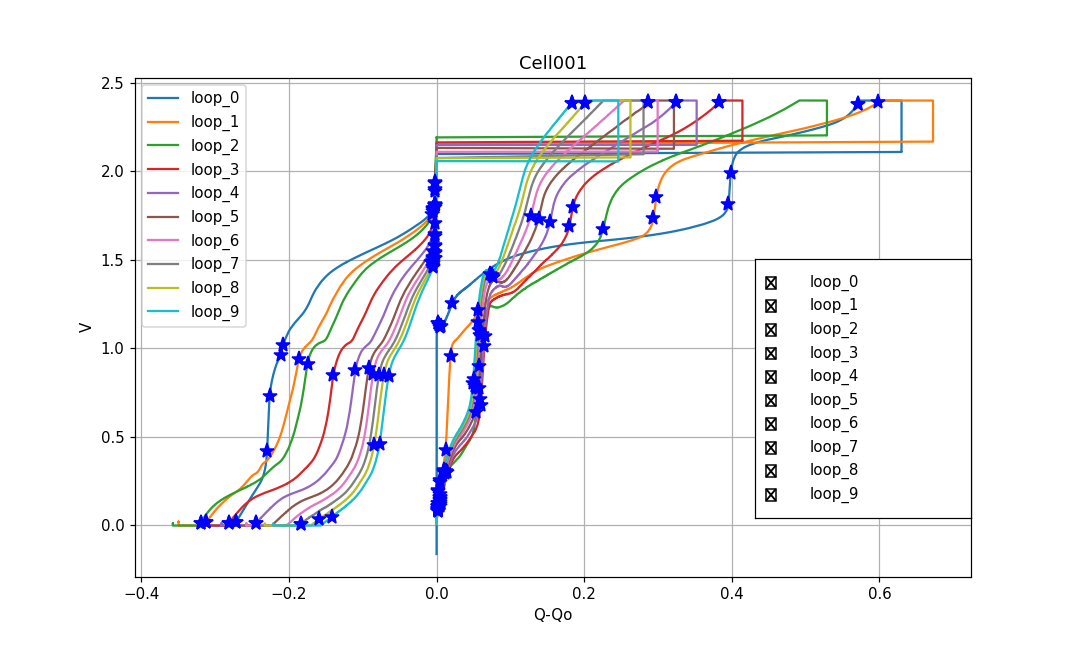

In [46]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `Ewe/V`,`(Q-Qo)/mA.h`,`loop_Nr`,`time/s` FROM ' +cell+ '.form_gcpl'
cellx_df = pd.read_sql(sql, Connection)

V = cellx_df['Ewe/V']
loop = cellx_df['loop_Nr']
t = cellx_df['time/s']
Q =cellx_df['(Q-Qo)/mA.h']

sql = 'SELECT `t`,`V`,`Q` FROM ' +cell+ '.turning_points_form'
tp_df = pd.read_sql(sql, Connection)

fig,ax = plt.subplots(figsize=(10,6))
plt.title(cell)
l = ax.plot(
    Q[loop==0],V[loop==0],
    Q[loop==1],V[loop==1],
    Q[loop==2],V[loop==2],
    Q[loop==3],V[loop==3],
    Q[loop==4],V[loop==4],
    Q[loop==5],V[loop==5],
    Q[loop==6],V[loop==6],
    Q[loop==7],V[loop==7],
    Q[loop==8],V[loop==8],
    Q[loop==9],V[loop==9]
       )
ax.legend(['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'])
ax.set_xlabel("Q-Qo")
ax.set_ylabel("V")

point_Q = ax.plot( tp_df['Q'],tp_df['V'],'*',markersize=10,visible=True,color='blue')
ax.grid()
## define the checkboxes
ax_cb = plt.axes([0.7,0.2,0.2,0.4])
cbs = CheckButtons(ax_cb,['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'],
                    actives=[True,True,True,True,True,True,True,True,True,True])

## updating function
def update(val):
    status = cbs.get_status()
    l[0].set_visible(status[0])
    l[1].set_visible(status[1])
    l[2].set_visible(status[2])
    l[3].set_visible(status[3])
    l[4].set_visible(status[4])
    l[5].set_visible(status[5])
    l[6].set_visible(status[6])
    l[7].set_visible(status[7])
    l[8].set_visible(status[8])
    l[9].set_visible(status[9])
    fig.canvas.draw()
cbs.on_clicked(update)


plt.show()

### cycling

<IPython.core.display.Javascript object>


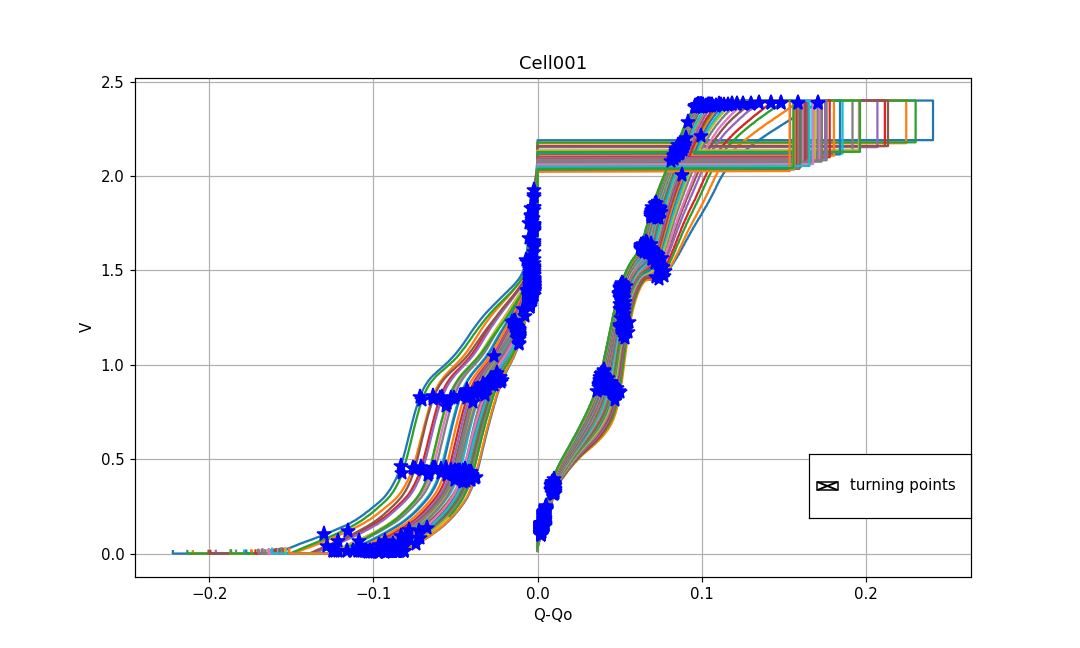

In [48]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `Ewe/V`,`Q charge/discharge/mA.h`,`cycle_Nr`,`time/s` FROM ' +cell+ '.cyc_gcpl'
cellx_df = pd.read_sql(sql, Connection)

V = cellx_df['Ewe/V'].copy()
cycle = cellx_df['cycle_Nr'].copy()
t = cellx_df['time/s'].copy()
Q =cellx_df['Q charge/discharge/mA.h'].copy()

sql = 'SELECT `t`,`V`,`Q` FROM ' +cell+ '.turning_points_cyc'
tp_df = pd.read_sql(sql, Connection)
fig,ax = plt.subplots(figsize=(10,6))
plt.title(cell)
[ax.plot(Q[cycle==i],V[cycle==i]) for i in np.unique(cycle)]
ax.set_xlabel("Q-Qo")
ax.set_ylabel("V")
point_Q = ax.plot( tp_df['Q'],tp_df['V'],'*',markersize=10,visible=True,color='blue')
## define the checkboxes
ax_cb = plt.axes([0.75,0.2,0.15,0.1])
cbs = CheckButtons(ax_cb,labels =['turning points'],actives=[True])
ax.grid()

def update(val):
    status = cbs.get_status()
    point_Q[0].set_visible(status[0])
    fig.canvas.draw()
cbs.on_clicked(update)

plt.show()

## clustering

In [51]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell007'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)


sql = 'SELECT `t`,`V`,`Q` FROM ' +cell+ '.turning_points_form WHERE Q>0'
tp_df = pd.read_sql(sql, Connection)
X = tp_df[['Q','V']].copy()

In [45]:
km.labels_

array([3, 3, 1, 1, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 0, 0, 3, 3, 2,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [52]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

In [37]:
km.cluster_centers_

array([[0.02377666, 1.37013143],
       [0.03981553, 1.73177467],
       [0.16766393, 2.27112714],
       [0.0548625 , 2.04556222]])

<IPython.core.display.Javascript object>


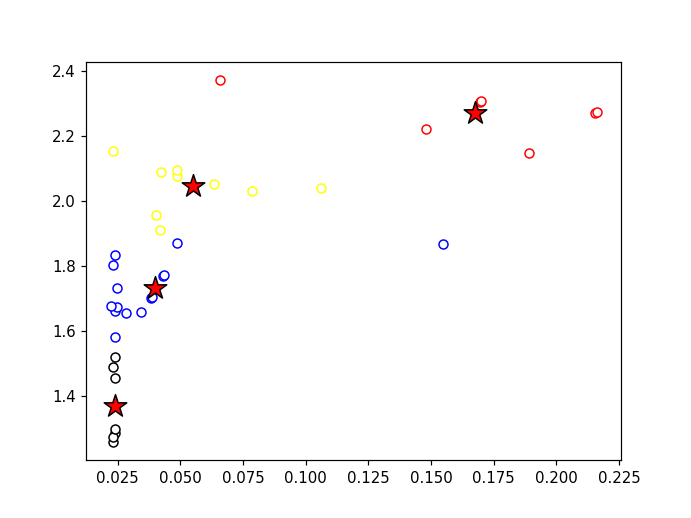

In [53]:
plt.figure()
plt.scatter(
   tp_df['Q'][km.labels_==0], tp_df['V'][km.labels_==0],
   c='white', marker='o',
   edgecolor='black'
)
plt.scatter(
   tp_df['Q'][km.labels_==1], tp_df['V'][km.labels_==1],
   c='white', marker='o',
   edgecolor='blue'
)
plt.scatter(
   tp_df['Q'][km.labels_==2], tp_df['V'][km.labels_==2],
   c='white', marker='o',
   edgecolor='red'
)
plt.scatter(
   tp_df['Q'][km.labels_==3], tp_df['V'][km.labels_==3],
   c='white', marker='o',
   edgecolor='yellow'
)

plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

D:\Study\Software\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<IPython.core.display.Javascript object>


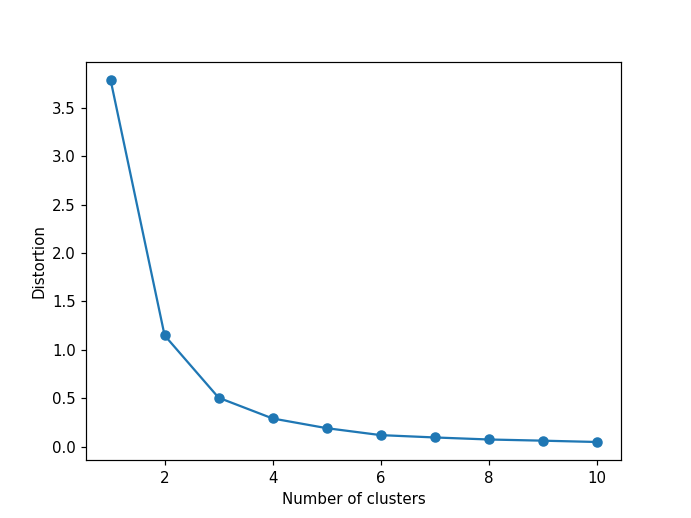

In [54]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.figure()
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## $\frac {dV}{dQ}$vs. Q

<IPython.core.display.Javascript object>


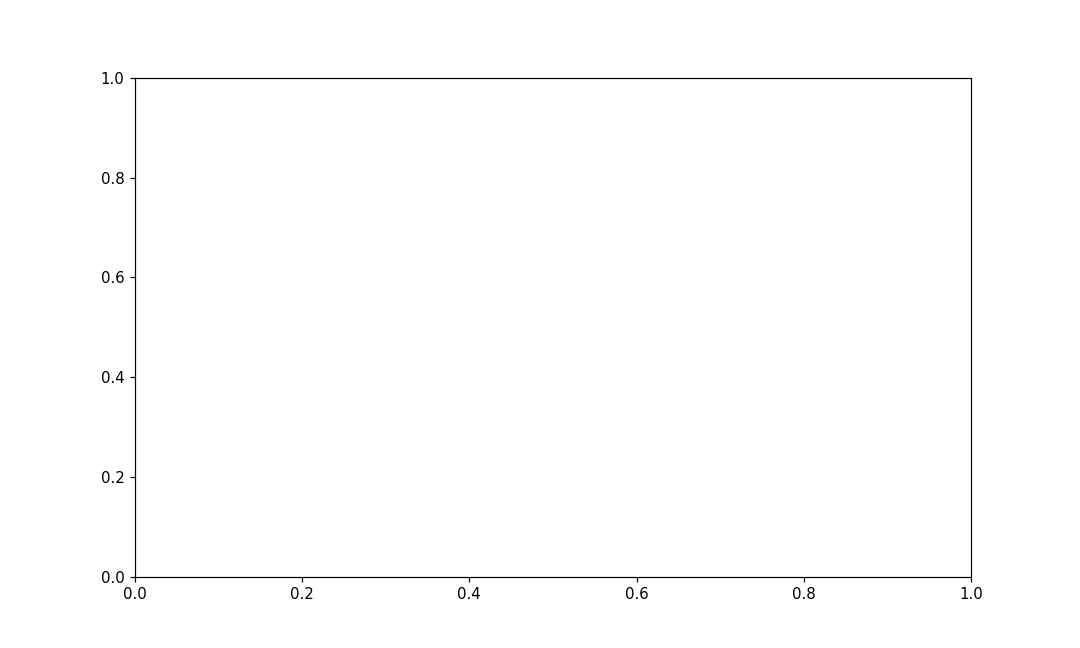

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [50]:
fig,ax = plt.subplots(figsize=(10,6))
l=[]
#savgol_filter
win_len = 179
p_order = 3
for i in range(0,10):
    dV = np.diff(V[loop==i],append=-1)
    dQ = np.diff(Q[loop==i],append=-1)
    dVdQ = np.zeros(dV.shape)
    idxNonZeros = np.where(dQ!=0)
    idxZeros = np.where(dQ==0)
    dVdQ[idxNonZeros] = dV[idxNonZeros]/dQ[idxNonZeros]
    dVdQ[idxZeros] = np.nan
    
    dVdQ[abs(dVdQ)>=200]=np.nan
    
    l = ax.plot(Q[loop==i],dVdQ)
ax.legend(['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'])

# EIS

## formation

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell008'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`loop_Nr`,`state of charge` FROM ' +cell+ '.form_geis'
cellx_df = pd.read_sql(sql, Connection)

fig, ax = plt.subplots(figsize=(8,8))
plt.title(cell)
Legend = []
for i in np.unique(cellx_df['loop_Nr']):
    for j in np.unique(cellx_df['state of charge']):
        f = np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)]['freq/Hz'])
        Z = np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
        Z = Z[:, 0] - 1j*Z[:, 1]
        f, Z = preprocessing.ignoreBelowX(f, Z)
        plot_nyquist(ax, Z)
        Legend = np.append(Legend,'loop'+str(i)+'state'+str(j))
ax.legend(Legend)
plt.show()

## cycling

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis'
cellx_df = pd.read_sql(sql, Connection)

fig, ax = plt.subplots(figsize=(10,4))
plt.title(cell)
Legend = []
for i in np.unique(cellx_df['cycle_Nr']):
    f = np.array(cellx_df[(cellx_df['cycle_Nr']==i)]['freq/Hz'])
    Z = np.array(cellx_df[(cellx_df['cycle_Nr']==i)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
    Z = Z[:, 0] - 1j*Z[:, 1]
    f, Z = preprocessing.ignoreBelowX(f, Z)
    plot_nyquist(ax, Z)
    Legend = np.append(Legend,'cycle'+str(i))
ax.legend(Legend)
plt.show()

## extract EIS data by low, medium and high frequency
use to represent the feutures in different f   
low = 0.107102Hz;    
medium = 425.194Hz;    
high = 10001Hz;

In [ ]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='Cell001'
cells = ['cell001','cell002','cell003','cell004','cell005','cell006','cell007','cell008']
low = 0.107102
medium = 425.149
high = 10001
for cell in cells:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`loop_Nr`,`state of charge` FROM ' +cell+ '.form_geis'
    cellx_df_form = pd.read_sql(sql, Connection)
    sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`cycle_Nr` FROM ' +cell+ '.cyc_geis'
    cellx_df_cyc = pd.read_sql(sql, Connection)   
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    eis_form = cellx_df_form[cellx_df_form['freq/Hz'].isin([low,medium,high])].sort_values(['freq/Hz','loop_Nr','state of charge'])
    eis_cyc = cellx_df_cyc[cellx_df_cyc['freq/Hz'].isin([low,medium,high])].sort_values(['freq/Hz','cycle_Nr'])
    eis_form.to_sql('eis_feature_form', engine, if_exists='replace',index=False)
    eis_cyc.to_sql('eis_feature_cyc', engine, if_exists='replace',index=False)
    print('eis features of {cell} extrated'.format(cell=cell))